
### Aleryc SERRANIA - 21204068

# Introduction

This report was created with a Jupyter notebook. You can find the original source of this notebook in the same folder (`report.ipynb`).
Source code of the implementations of the algorithms can be found inside `src` folder. A Makefile is provided to compile the code.

The variants for this assignments are the following:

1. Manually written straightforward non-blocked ijk algorithm;
2. Blocked ijk algorithm using ATLAS calls to compute multiplication of blocks;
3. Blocked kij algorithm using ATLAS calls to compute multiplication of blocks;
4. Compare the fastest program with BLAS dgemm routine.

I built a python script `run_exp.py` to get results for different sizes of matrix and block and also to run multiple iterations of the same configuration to get an average of the execution time (25 iterations). The results are compiled inside `data.csv`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gs
import numpy as np

plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('data.csv')

# Detailed performance for each algorithm

## Straightforward non-blocked ijk

In [ ]:
data[data['filename'] == 'non_blocked_ijk.out']

## Blocked ijk with ATLAS

Timing unit is second.

In [ ]:
data[data['filename'] == 'blocked_ijk_atlas.out']

## Blocked kij with ATLAS

In [ ]:
data[data['filename'] == 'blocked_kij_atlas.out']

## BLAS dgemm routine

In [ ]:
data[data['filename'] == 'blas_routine.out']

# Execution times of blocked algorithms in function of matrix size

We can plot the dependency of the execution on the matrix and block sizes in a 3d plot.
I am using a log scale for the execution time since the differences in time are either really small or really big. 

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(25, 20))
fig.suptitle("Dependency of execution times on matrix and block sizes", fontsize=40)
spec2 = gs.GridSpec(ncols=3, nrows=2, figure=fig)
for i, f in enumerate(['blocked_ijk_atlas.out', 'blocked_kij_atlas.out']):
    Xs = np.array(data[data['filename'] == f]['matrix_size'])
    Ys = np.array(data[data['filename'] == f]['block_size'])
    Zs = np.log10(np.array(data[data['filename'] == f]['timing']))
    for j, angle in enumerate([40, 100, 160]):
        ax = fig.add_subplot(spec2[i, j], projection='3d')
        ax.set_xlabel('matrix size')
        ax.set_ylabel('block size')
        ax.set_zlabel('timing log10(sec)')
        ax.set_title(f, fontsize=20)
        ax.view_init(30, 40 + angle)
        surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=mpl.cm.jet, linewidth=0)
        fig.colorbar(surf)

We can also plot in 2d for each matrix size:

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(25, 25))
fig.suptitle("Dependency of execution times on matrix and block sizes", fontsize=40)
spec2 = gs.GridSpec(ncols=3, nrows=5, figure=fig)
sizes = sorted(list(set(data['matrix_size'])))
for i, s in enumerate(sizes):
    ax = fig.add_subplot(spec2[i // 3, i % 3])
    subdata = data[data['matrix_size'] == s]
    bijk_data = subdata.loc[data['filename'] == 'blocked_ijk_atlas.out'].copy()
    bkij_data = subdata.loc[data['filename'] == 'blocked_kij_atlas.out'].copy()
    bijk_data.plot.line(x='block_size', y=f'timing', ax=ax, logy=True)
    bkij_data.plot.line(x='block_size', y=f'timing', ax=ax, logy=True)
    ax.set_xlabel('block size')
    ax.set_ylabel('timing')
    ax.set_title(f'Matrix Size: {s}', fontsize=20)
    ax.legend([f'ijk block', f'kij block'], loc='lower right')

As we can see from these plots, the two blocked algorithm are similar in shape and in execution times.
Blocking appears to not help with performance since there is no significant speedup when the block size is half the size of the matrix

## Speedup of the blocked algorithms over the non-blocked one

Speedup is computed as following: 
$$S(m, b) = \frac{T_{nonblocked}(m)}{T_{blocked}(m, b)}$$ 
where $m$ is matrix size and $b$ is block size


In [ ]:
sizes = set(data['matrix_size'])
for s in sizes:
    non_blocked_timing = data.loc[data['matrix_size'] == s].loc[data['filename'] == 'non_blocked_ijk.out'].iloc[0].at['timing']
    data.loc[data['matrix_size'] == s, 'speedup'] =  non_blocked_timing / data.loc[data['matrix_size'] == s, 'timing']

We can plot the speedup in 3d and 2d:

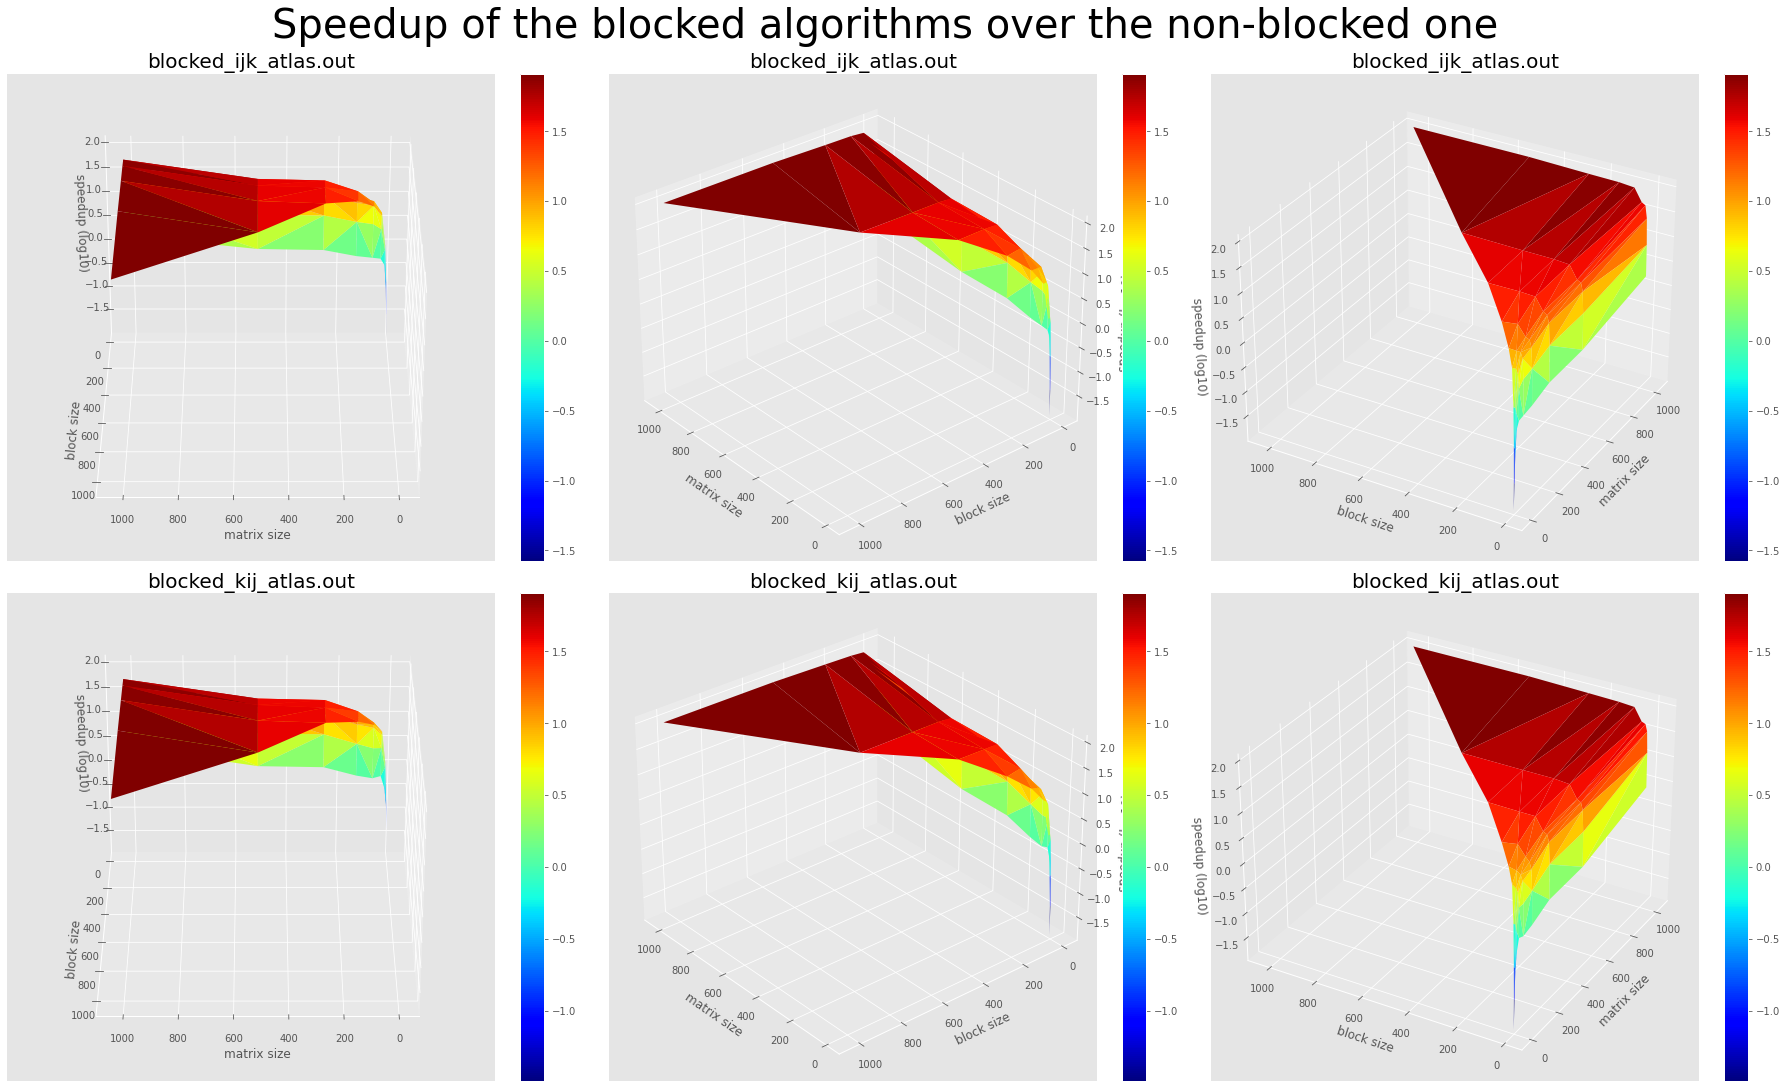

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(25, 15))
fig.suptitle("Speedup of the blocked algorithms over the non-blocked one", fontsize=40)
spec2 = gs.GridSpec(ncols=3, nrows=2, figure=fig)


for i, f in enumerate(['blocked_ijk_atlas.out', 'blocked_kij_atlas.out']):
    Xs = np.array(data[data['filename'] == f]['matrix_size'])
    Ys = np.array(data[data['filename'] == f]['block_size'])
    Zs = np.log10(np.array(data[data['filename'] == f]['speedup']))
    for j, angle in enumerate([50, 100, 170]):
        ax = fig.add_subplot(spec2[i, j], projection='3d')
        ax.set_title(f, fontsize=20)
        ax.set_xlabel('matrix size')
        ax.set_ylabel('block size')
        ax.set_zlabel('speedup (log10)')
        ax.view_init(30, 40 + angle)
        surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=mpl.cm.jet, linewidth=0)
        fig.colorbar(surf)

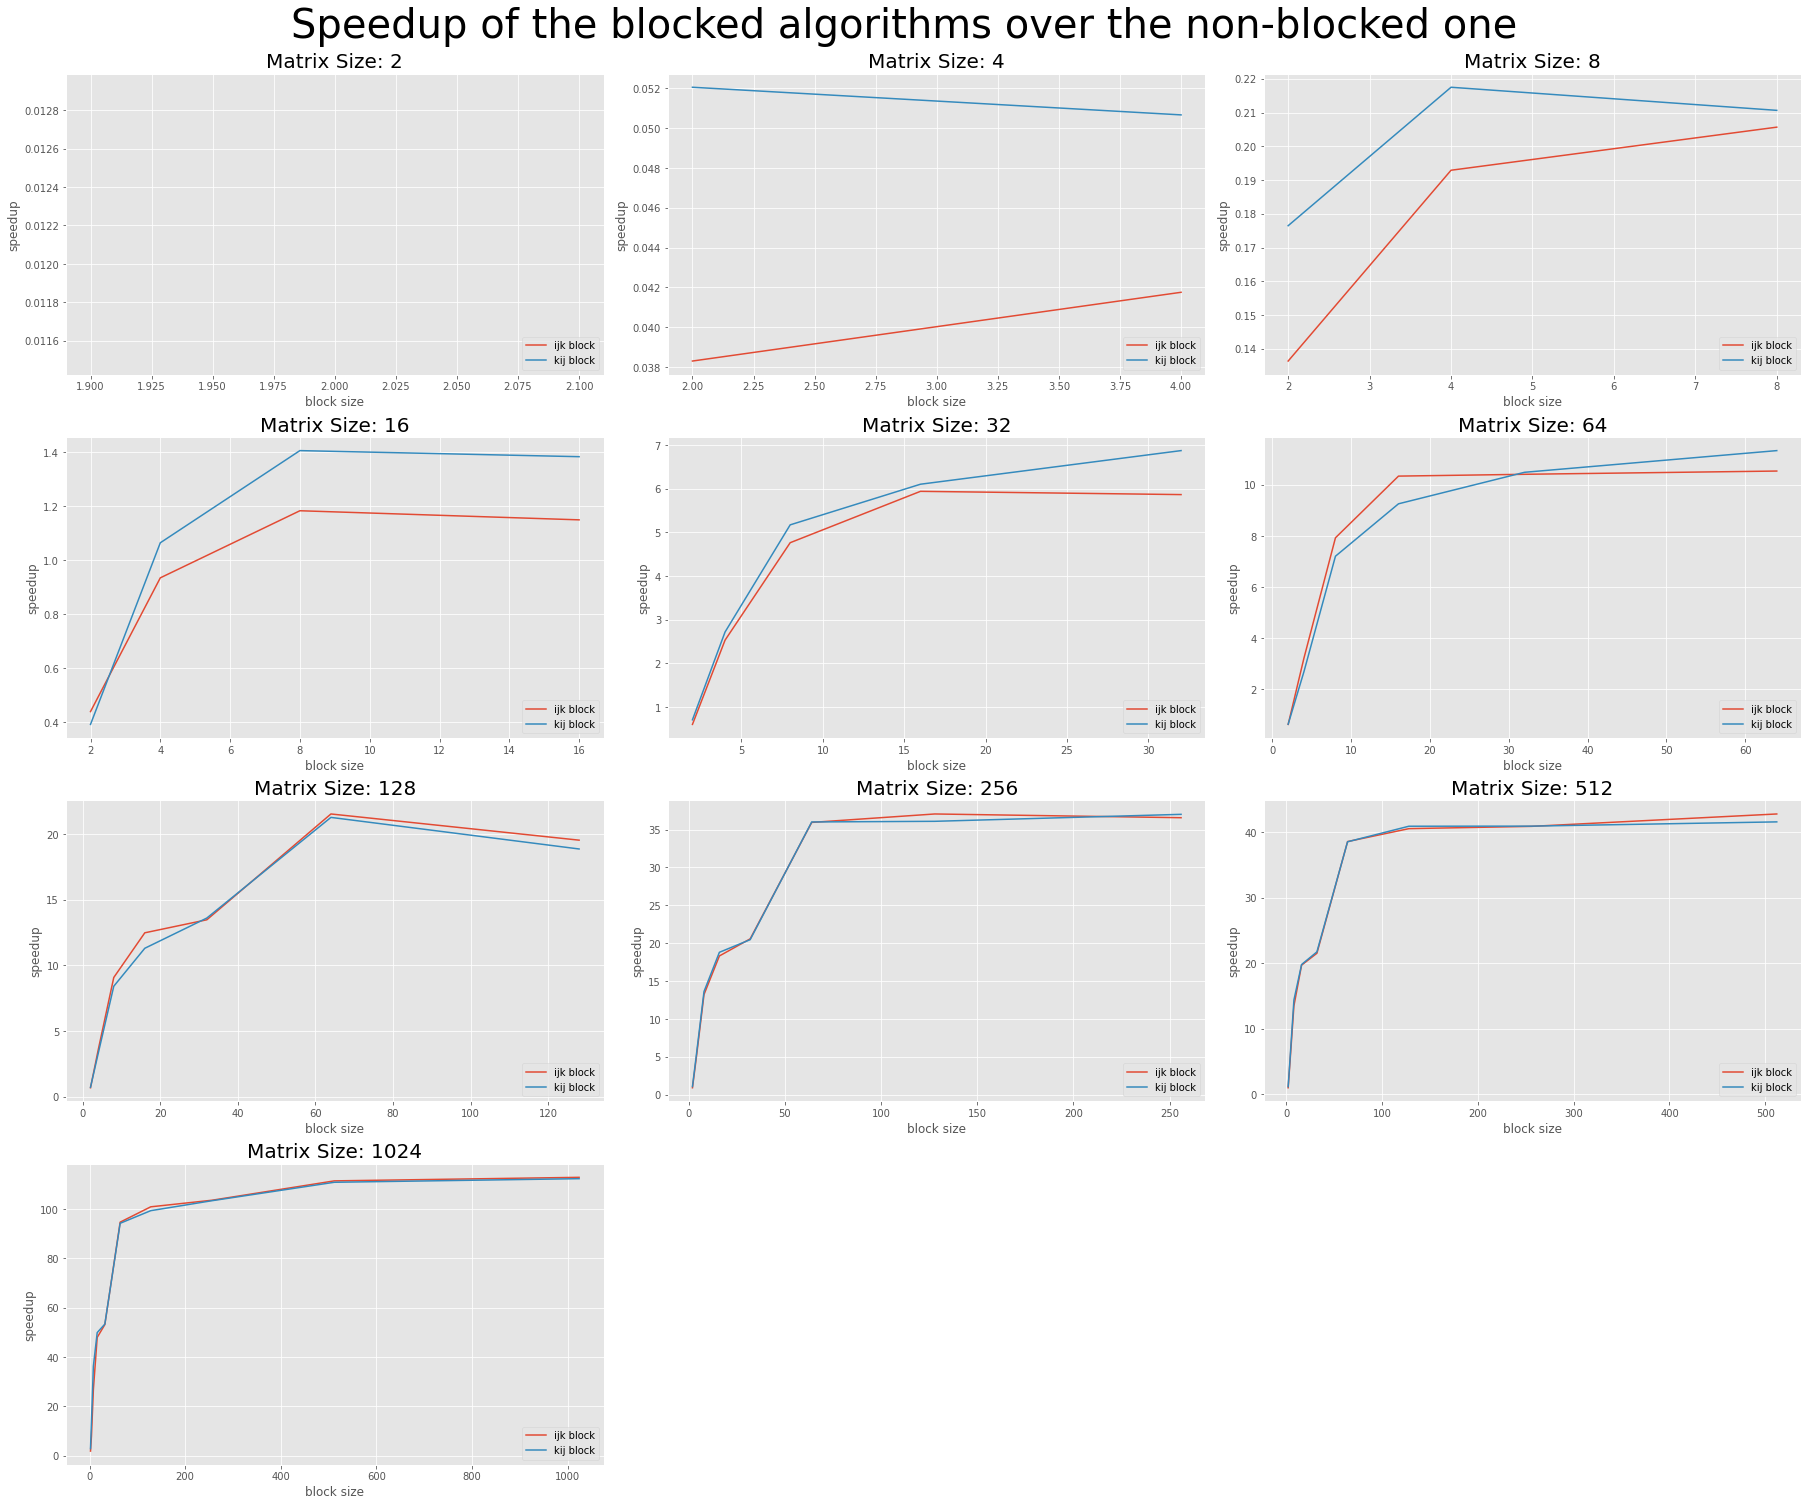

In [25]:
fig = plt.figure(constrained_layout=True, figsize=(25, 25))
fig.suptitle("Speedup of the blocked algorithms over the non-blocked one", fontsize=40)
spec2 = gs.GridSpec(ncols=3, nrows=5, figure=fig)
sizes = sorted(list(set(data['matrix_size'])))
for i, s in enumerate(sizes):
    ax = fig.add_subplot(spec2[i // 3, i % 3])
    subdata = data[data['matrix_size'] == s]
    bijk_data = subdata.loc[data['filename'] == 'blocked_ijk_atlas.out'].copy()
    bkij_data = subdata.loc[data['filename'] == 'blocked_kij_atlas.out'].copy()
    non_blocked_timing = subdata.loc[data['filename'] == 'non_blocked_ijk.out'].iloc[0].at['timing']
    bijk_data['speedup'] = non_blocked_timing / bijk_data['timing']
    bkij_data['speedup'] = non_blocked_timing / bkij_data['timing']
    bijk_data.plot.line(x='block_size', y=f'speedup', ax=ax)
    bkij_data.plot.line(x='block_size', y=f'speedup', ax=ax)
    ax.set_xlabel('block size')
    ax.set_ylabel('speedup')
    ax.set_title(f'Matrix Size: {s}', fontsize=20)
    ax.legend([f'ijk block', f'kij block'], loc='lower right')

As we can see, the speedup can be up to a factor of $10^1$ for large matrices ($m > 64$) and $10^2$ for larger ones ($m > 1024$). For smaller matrix, we notice worse performance in comparison with the straightforward algorithm.
There is no significant speedup between the ijk and kij algorithm any matrix size.
However, I don't think we ca not conclude right now that blocked algorithms are faster than non-blocked ones since we are using ATLAS calls for the blocked algorithms which are already much faster than any naive implementation.

## Comparison with BLAS dgemm

This time, we will compare our blocked algorithms with BLAS dgemm routine.

In [26]:
# Compute speedup over blas call
sizes = set(data['matrix_size'])
for s in sizes:
    blas_simple_timing = data.loc[data['matrix_size'] == s].loc[data['filename'] == 'blas_routine.out'].iloc[0].at['timing']
    data.loc[data['matrix_size'] == s, 'speedup'] = blas_simple_timing / data.loc[data['matrix_size'] == s, 'timing']

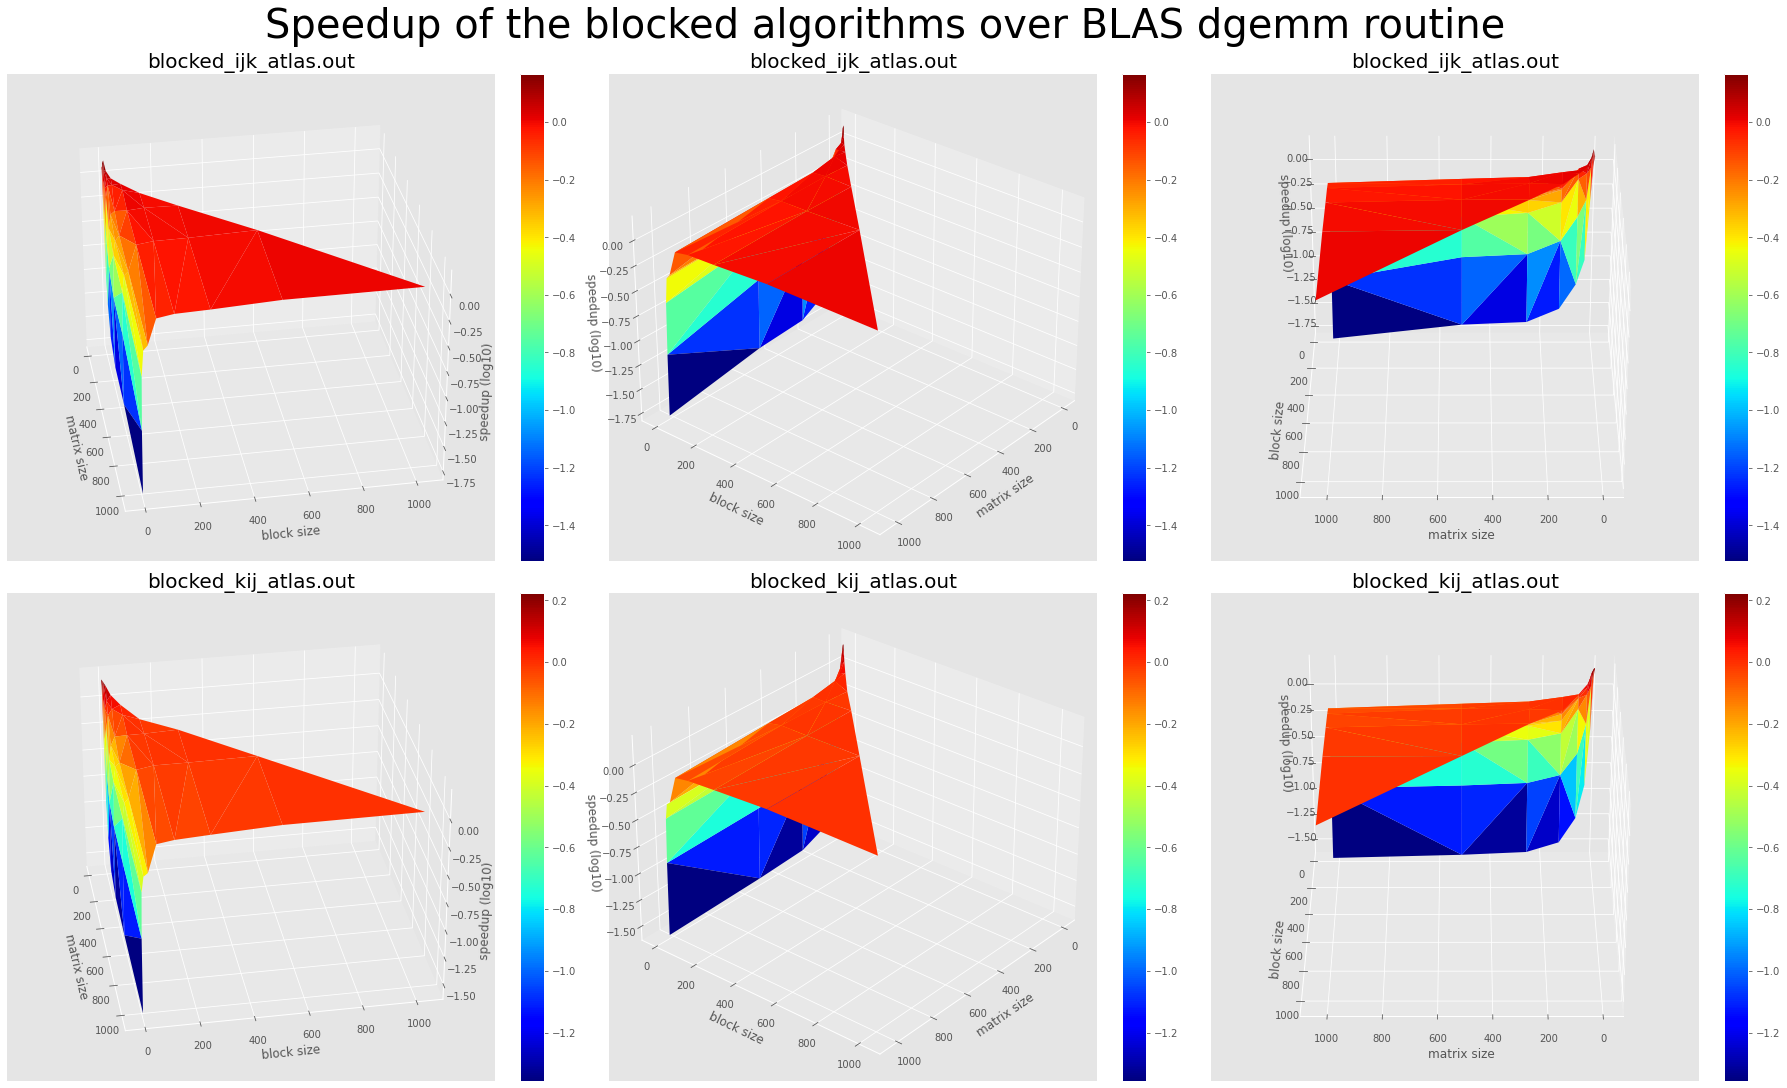

In [27]:
fig = plt.figure(constrained_layout=True, figsize=(25, 15))
fig.suptitle("Speedup of the blocked algorithms over BLAS dgemm routine", fontsize=40)
spec2 = gs.GridSpec(ncols=3, nrows=2, figure=fig)
for i, f in enumerate(['blocked_ijk_atlas.out', 'blocked_kij_atlas.out']):
    Xs = np.array(data[data['filename'] == f]['matrix_size'])
    Ys = np.array(data[data['filename'] == f]['block_size'])
    Zs = np.log10(np.array(data[data['filename'] == f]['speedup']))
    for j, angle in enumerate([50, 100, 150]):
        ax = fig.add_subplot(spec2[i, j], projection='3d')
        ax.set_title(f, fontsize=20)
        ax.set_xlabel('matrix size')
        ax.set_ylabel('block size')
        ax.set_zlabel('speedup (log10)')
        ax.view_init(30, -60 + angle)
        surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=mpl.cm.jet, linewidth=0)
        fig.colorbar(surf)

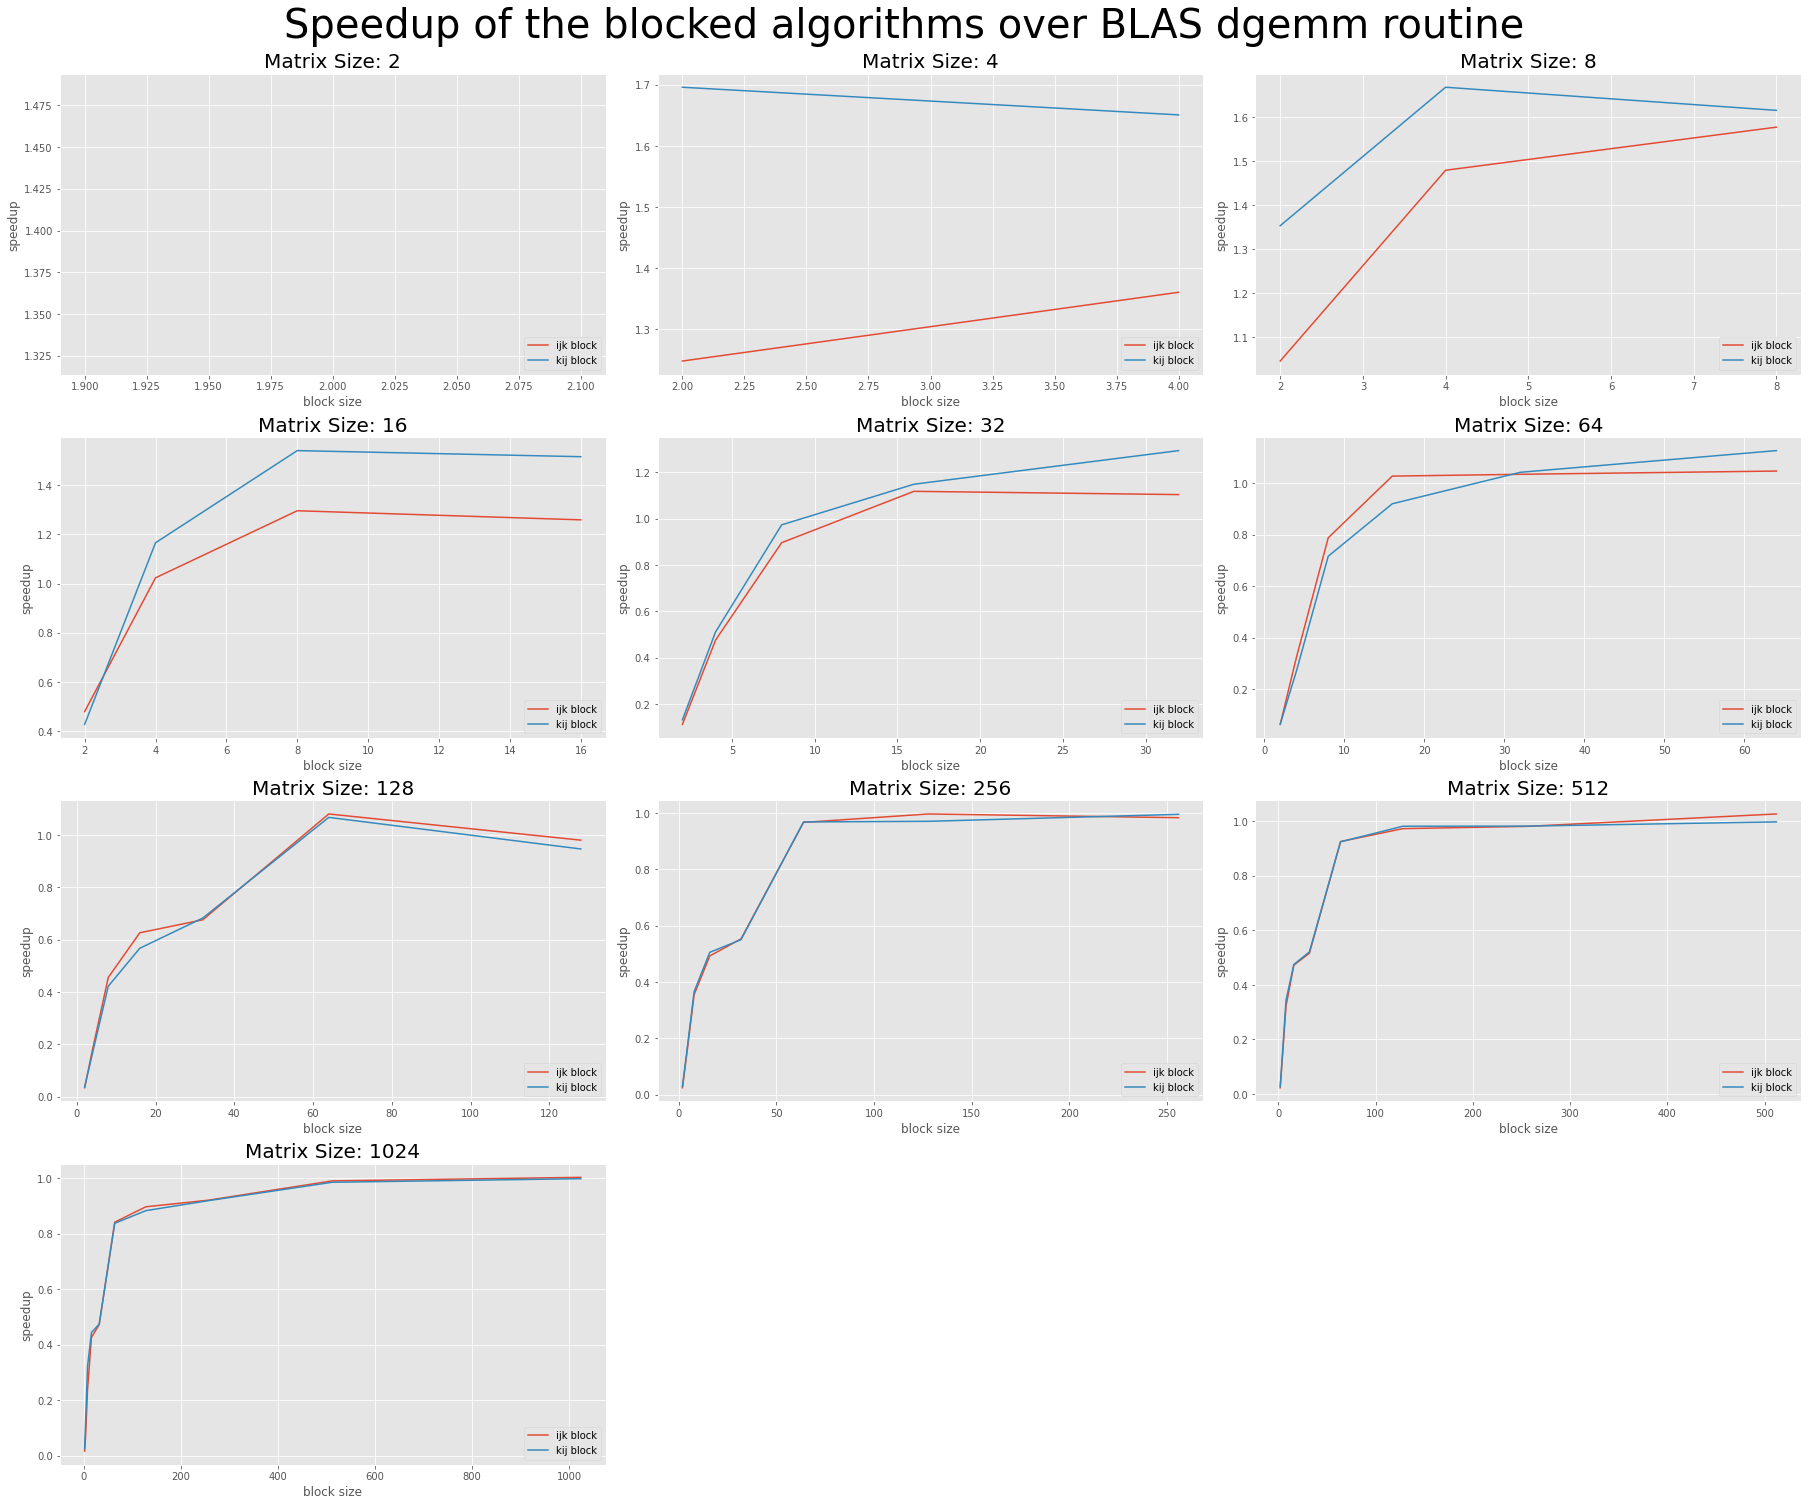

In [28]:
fig = plt.figure(constrained_layout=True, figsize=(25, 25))
fig.suptitle("Speedup of the blocked algorithms over BLAS dgemm routine", fontsize=40)
spec2 = gs.GridSpec(ncols=3, nrows=5, figure=fig)
sizes = sorted(list(set(data['matrix_size'])))
for i, s in enumerate(sizes):
    ax = fig.add_subplot(spec2[i // 3, i % 3])
    subdata = data[data['matrix_size'] == s]
    bijk_data = subdata.loc[data['filename'] == 'blocked_ijk_atlas.out'].copy()
    bkij_data = subdata.loc[data['filename'] == 'blocked_kij_atlas.out'].copy()
    blas_routine = subdata.loc[data['filename'] == 'blas_routine.out'].iloc[0].at['timing']
    bijk_data['speedup'] = blas_routine / bijk_data['timing']
    bkij_data['speedup'] = blas_routine / bkij_data['timing']
    bijk_data.plot.line(x='block_size', y=f'speedup', ax=ax)
    bkij_data.plot.line(x='block_size', y=f'speedup', ax=ax)
    ax.set_xlabel('block size')
    ax.set_ylabel('speedup')
    ax.set_title(f'Matrix Size: {s}', fontsize=20)
    ax.legend([f'ijk block', f'kij block'], loc='lower right')

The speedup is generally under 1 for matrices with $m > 64$ and any block size. Blocking appears to lower the performance for matrix larger than 64x64 when using ATLAS calls.
I expected blocking algorithms to give better performance since they reduce cache misses by reusing the same small blocks frequently.
One reason I can think of why blocking in this case doesn't improve the performance is the `dgemm` routine's cost of overhead makes the multiple calls inefficient for small matrices.
It means that for $N_b$ number of blocks, we have $N_b.t_{overhead} + t_{proc blocked} < t_{proc}$.
